<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/object_detection/vision_transformer_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/lucidrains/vit-pytorch.git

In [ ]:
!pip install vit-pytorch

In [ ]:
# check code
import torch
from vit_pytorch import ViT

v = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

img = torch.randn(1, 3, 256, 256)

preds = v(img) # (1, 1000)

In [ ]:
!pip install scikit-learn timm tqdm 

In [ ]:
!unzip /content/drive/MyDrive/dogs-vs-cats-redux-kernels-edition/train.zip
!unzip /content/drive/MyDrive/dogs-vs-cats-redux-kernels-edition/test.zip

In [ ]:
!mkdir /content/vit-pytorch/examples/data
!mv train /content/vit-pytorch/examples/data/
!mv test /content/vit-pytorch/examples/data/

In [ ]:
!pip install linformer

In [ ]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
import seaborn as sns
import timm

In [ ]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
device = 'cuda'

In [ ]:
import os
os.chdir('/content/vit-pytorch/examples')
train_dir = 'data/train'
test_dir = 'data/test'
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [ ]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

In [ ]:
# Random plots
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [ ]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [ ]:
# Image Augumentation
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [ ]:
img_path = "data/train/dog.12208.jpg"
label = img_path.split("/")[-1].split(".")[0]
label = 1 if label == "train/dog" else 0 #ここを書換えてください
print(label)

In [ ]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "train/dog" else 0 #ここを書換えてください

        return img_transformed, label

In [ ]:
# Dataset and Datalaoder
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [ ]:
# efficient attention
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [ ]:
# Create model
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [ ]:
import timm
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=2)
model.to(device)

In [ ]:
# Train settings
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
# Training
##ここを追記↓##
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
##############

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

##ここを追記↓##
    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)
##############

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0036 - acc: 0.9985 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



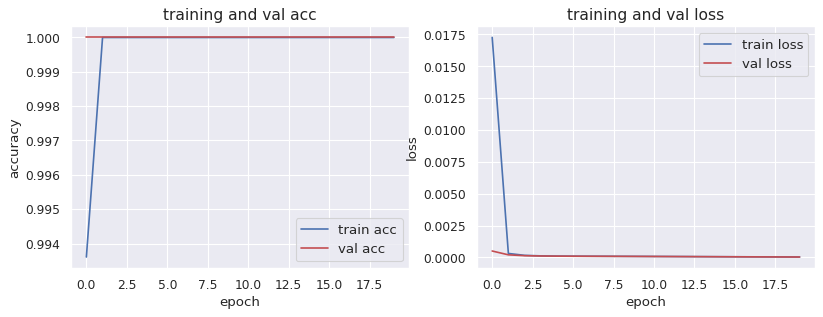

In [ ]:
# Visualize Training results
#出力したテンソルのデバイスをCPUへ切り替える
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)
    
    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)
    
    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)
    
    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()